# ConvNEXT for DR detection

## Setup

### Google Drive Access

In [1]:
from google.colab import drive
import os

# Parameters
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/APTOS2019'
PREP_PATH = DATASET_PATH + '/preprocessed/'
MODEL_PATH= '/content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/APTOS2019/checkpoints/checkpoint_resnet.pth'

# Load Dataset From Drive
drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

if not os.path.exists(PREP_PATH):
  os.mkdir(PREP_PATH)

if not os.path.exists(DATASET_PATH + "/checkpoints"):
  os.mkdir(DATASET_PATH + "/checkpoints")

Mounted at /content/drive
CWD: /content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/APTOS2019


### Dataset Download

In [ ]:
'''
# Dataset with already preprocessed images
!gdown --id 1TqlyF-VVLcuebqQcWuAKnG7ay3IKjylC
!unzip APTOS2019.zip

# Parameters
DATASET_PATH = '/content/APTOS2019'
PREP_PATH = DATASET_PATH + "/preprocessed/"
MODEL_PATH= '/content/APTOS2019/checkpoints/checkpoint.pth'

if not os.path.exists(PREP_PATH):
  os.mkdir(PREP_PATH)

if not os.path.exists("/checkpoints"):
  os.mkdir("/checkpoints")
'''

'\n# Dataset with already preprocessed images\n!gdown --id 1TqlyF-VVLcuebqQcWuAKnG7ay3IKjylC\n!unzip APTOS2019.zip\n\n# Parameters\nDATASET_PATH = \'/content/APTOS2019\'\nPREP_PATH = DATASET_PATH + "/preprocessed/"\nMODEL_PATH= \'/content/checkpoints/checkpoint.pth\'\n\nif not os.path.exists(PREP_PATH):\n  os.mkdir(PREP_PATH)\n\nif not os.path.exists("/checkpoints"):\n  os.mkdir("/checkpoints")\n'

### Environment Setup

In [2]:
!pip install torchinfo
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.3-py3-none-any.whl size=32263 sha256=257572aa8b44d86afbd936fb9012cc88ccbb87e12ab88e9306e5cf849b3eda96
  Stored in directory: /root/.cache/pip/wheels/77/05/47/36e06c7cdf46685b5a9e30686a1f93bff3e95a91bf1404c75d
Successfully built grad-cam


## Imports and global parameters

In [3]:
import pandas as pd
import cv2
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
import shutil
import torch
import torchvision
from torchvision import models
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import random_split
import torchvision.transforms as transforms
from matplotlib import pyplot as plt 

%matplotlib inline

device = "cpu"
if torch.cuda.is_available():
  device = "cuda"

In [6]:
# Model Hyperparameters

IMG_SIZE = 512
N_CHANNELS = 3
BATCH_SIZE = 10

# Number of epochs for the batch training
NUM_EPOCHS = 30
# Number of epochs for the warmup training
NUM_INIT_EPOCHS = 4
# Learning Rate for the warmup training
LR_INIT = 0.00001
# Learning Rate for the batch training
LR = 0.0001

# LR Reduction Factor 
DECAY_FACTOR = 0.1
# Minimum Learning Rate for LR Reduction on Plateau
LR_TSH = 0.000001
# Number of epochs to wait before LR reduction 
# when no improvement is detected
PATIENCE = 1

# Number of epochs to wait before Early Stopping 
# when no improvement is detected
ES_PATIENCE = 3

N_CLASSES = 5
CLASSES = [ "No DR", "Mild", "Moderate", "Severe", "Proliferative DR" ]

# Maximum number of CPU cores available for faster preprocessing
N_CORES = 4

## Dataset Preparation

In [ ]:
'''
import multiprocessing
from multiprocessing.pool import ThreadPool

# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref for circle crop: https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess(id_code):
  path = DATASET_PATH + "/train_images/" + id_code + ".png"

  if(os.path.isfile(path) == False):
    print(id_code + " does not exist!")
    return

  img = cv2.imread(path)

  # Circle crop
  img = circle_crop(img)

  cv2.imwrite(PREP_PATH + id_code + ".png", cv2.resize(img, (IMG_SIZE,IMG_SIZE)))


def multiprocessor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess, imgs)
    return results

dataset = pd.read_csv("train.csv")

multiprocessor(4, list(dataset.id_code.values))
'''

'\nimport multiprocessing\nfrom multiprocessing.pool import ThreadPool\n\n# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook\n# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook\n# ref for circle crop: https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb\ndef crop_image_from_gray(img,tol=7):\n    if img.ndim ==2:\n        mask = img>tol\n        return img[np.ix_(mask.any(1),mask.any(0))]\n    elif img.ndim==3:\n        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n        mask = gray_img>tol\n        \n        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]\n        if (check_shape == 0): # image is too dark so that we crop out everything,\n            return img # return original image\n        else:\n            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]\n            img2=img[

In [5]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class DrDetectionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        img = read_image(path + ".png")
        lbl = self.labels.iloc[idx, 1]
        if self.transform:
            img = self.transform(img)
        return img, lbl

global_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.2786802, 0.2786802, 0.2786802], [0.16637428, 0.16637428, 0.16637428])
    ])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda image: image.convert('RGB')),
    # Data Augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.2786802, 0.2786802, 0.2786802], [0.16637428, 0.16637428, 0.16637428])
    ])

dataset = DrDetectionDataset(DATASET_PATH + "/train.csv", PREP_PATH, transform = global_transforms)

In [6]:
#Train-test-validation split

# Set manual seed for reproducible results
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 60% train, 20% test, 20% valid
train_size = int(0.8 * len(dataset))
test_val_size = (len(dataset) - train_size)

train_dataset, test_dataset = random_split(dataset, [train_size, test_val_size])

train_size = int(len(train_dataset) - test_val_size)
train_dataset, valid_dataset = random_split(train_dataset, [train_size, test_val_size])

train_dataset.dataset.dataset.transform = train_transforms
'''
# Use a Weighted Sampler to fix class imbalances in the training set
class_count = np.zeros(5)
for image, label in train_dataset:
  class_count[label] +=1

class_weights = 1. / class_count
weights = np.array([])

for image, label in train_dataset:
  weights = np.append(weights, class_weights[label])
  
weights = torch.from_numpy(weights)

weighted_sampler = WeightedRandomSampler(weights=weights,num_samples=len(train_dataset),replacement=True)

print("Train size: ", len(train_dataset))
print("Val size: ", len(valid_dataset))
print("Test size: ", len(test_dataset))
'''
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Training

## Get Model

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, N_CLASSES)
model = model.to(device)
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train

### Warmup Training

In [ ]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR_INIT)

top_accuracy = 0.0

# Loop through each epoch
for epoch in range(NUM_INIT_EPOCHS):
  train_loss = 0.0
  
  train_correct = 0
  train_total = 0

  for data, labels in train_loader:
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(data)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

    # print statistics
    train_loss += loss.item()
    
  valid_loss = 0.0
  val_correct = 0
  val_total = 0

  for data, labels in valid_loader:
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

      outputs = model(data)
      loss = loss_fn(outputs,labels)
      valid_loss = loss.item() * data.size(0)

      _, predicted = torch.max(outputs.data, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  val_accuracy = (100 * val_correct) // val_total

  print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Training Accuracy: {100 * train_correct // train_total}' )
  print(f'\t\t Validation Loss: {valid_loss / len(valid_loader)} \t\t Validation Accuracy: {val_accuracy}')
  if val_accuracy > top_accuracy:
      print(f'Validation Accuracy Increased({top_accuracy:.6f}--->{val_accuracy:.6f}) \t Saving The Model')
      top_accuracy = val_accuracy
      # Save Model
      torch.save(model, MODEL_PATH)


Epoch 1 		 Training Loss: 1.2535818430510435 		 Training Accuracy: 43
		 Validation Loss: 0.036050293091181164 		 Validation Accuracy: 58
Validation Accuracy Increased(0.000000--->58.000000) 	 Saving The Model
Epoch 2 		 Training Loss: 1.0304121743549 		 Training Accuracy: 58
		 Validation Loss: 0.04621762198370856 		 Validation Accuracy: 56
Epoch 3 		 Training Loss: 0.9120034017346123 		 Training Accuracy: 62
		 Validation Loss: 0.056019530103013325 		 Validation Accuracy: 60
Validation Accuracy Increased(58.000000--->60.000000) 	 Saving The Model
Epoch 4 		 Training Loss: 0.8392773101275618 		 Training Accuracy: 67
		 Validation Loss: 0.03636532458099159 		 Validation Accuracy: 62
Validation Accuracy Increased(60.000000--->62.000000) 	 Saving The Model


### Training

In [ ]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
#https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
#https://clay-atlas.com/us/blog/2021/08/25/pytorch-en-early-stopping/

model = torch.load(MODEL_PATH).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=DECAY_FACTOR, patience=PATIENCE, 
                                                       threshold=LR_TSH, verbose=True)

prev_valid_loss = 100
trigger_times = 0

# Loop through each epoch
for epoch in range(NUM_EPOCHS):
  train_loss = 0.0

  train_correct = 0
  train_total = 0

  for data, labels in train_loader:

    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(data)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

    # print statistics
    train_loss += loss.item()
    
  valid_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for data, labels in valid_loader:
      if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

        outputs = model(data)
        loss = loss_fn(outputs,labels)
        valid_loss = loss.item() * data.size(0)

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
  

  # Early stopping
  if valid_loss > prev_valid_loss:
    trigger_times += 1
    print('trigger times:', trigger_times)

    if trigger_times >= ES_PATIENCE:
      print('Early stopping!')
      break

  else:
    trigger_times = 0

  prev_valid_loss = valid_loss

  scheduler.step(valid_loss)

  val_accuracy = (100 * val_correct) // val_total

  print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Training Accuracy: {100 * train_correct // train_total}' )
  print(f'\t\t Validation Loss: {valid_loss / len(valid_loader)} \t\t Validation Accuracy: {val_accuracy}')
  if val_accuracy > top_accuracy:
      print(f'Validation Accuracy Increased({top_accuracy:.6f}--->{val_accuracy:.6f}) \t Saving The Model')
      top_accuracy = val_accuracy
      # Save Model
      torch.save(model, MODEL_PATH)


Epoch 1 		 Training Loss: 0.841465799510479 		 Training Accuracy: 65
		 Validation Loss: 0.03797698423669145 		 Validation Accuracy: 58
trigger times: 1
Epoch 2 		 Training Loss: 0.665825456854972 		 Training Accuracy: 74
		 Validation Loss: 0.043917006737477074 		 Validation Accuracy: 63
Validation Accuracy Increased(62.000000--->63.000000) 	 Saving The Model
trigger times: 2
Epoch 00003: reducing learning rate of group 0 to 1.0000e-05.
Epoch 3 		 Training Loss: 0.5365844953466545 		 Training Accuracy: 80
		 Validation Loss: 0.1738299743549244 		 Validation Accuracy: 66
Validation Accuracy Increased(63.000000--->66.000000) 	 Saving The Model
Epoch 4 		 Training Loss: 0.3928652510385622 		 Training Accuracy: 86
		 Validation Loss: 0.035965583614400914 		 Validation Accuracy: 66
Epoch 5 		 Training Loss: 0.3435063535855575 		 Training Accuracy: 88
		 Validation Loss: 0.023908135858741967 		 Validation Accuracy: 69
Validation Accuracy Increased(66.000000--->69.000000) 	 Saving The Model


# Test on whole test-set

In [ ]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
model = torch.load(MODEL_PATH).to(device)

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        # the class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy on the 733 test images: {100 * correct // total} %')

Accuracy on the 733 test images: 72 %


No DR :  86.9 %
Mild :  54.4 %
Moderate :  57.9 %
Severe :  60.5 %
Proliferative DR :  52.0 %


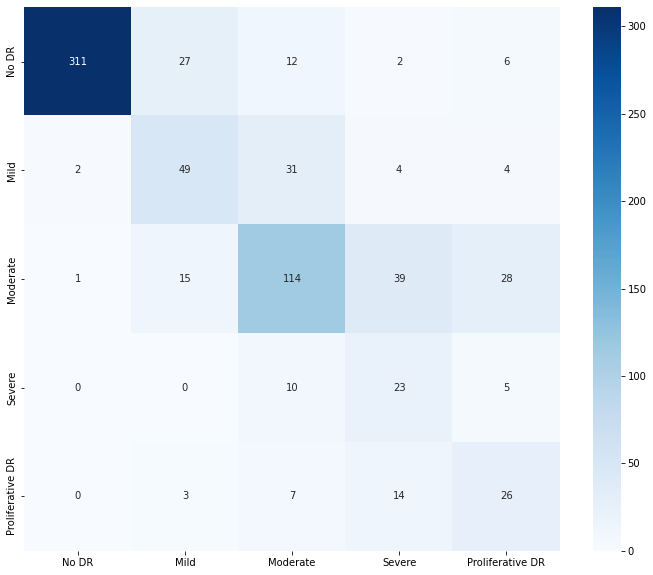

In [7]:
# conf matrix: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

# load model
model = torch.load(MODEL_PATH).to(device)

# prepare to count predictions for each class
predicted = []
actual = []

correct = {diagnosis: 0 for diagnosis in CLASSES}
total = {diagnosis: 0 for diagnosis in CLASSES}

with torch.no_grad():
    for images, labels in test_loader:
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Save predictions and actual labels for the confusion matrix
        predicted.extend(predictions.tolist())
        actual.extend(labels.tolist())

        for label, prediction in zip(labels, predictions):
            total[CLASSES[label]] += 1
            if label == prediction:
                correct[CLASSES[label]] += 1
            
# print accuracy for each class
for diagnosis, count in correct.items():
    accuracy = 100 * float(count) / total[diagnosis]
    print(diagnosis, ": ", f"{accuracy:.1f}", "%")

# Build confusion matrix
cf_matrix = confusion_matrix(np.array(actual), np.array(predicted))
df_cm = pd.DataFrame(cf_matrix, index = [i for i in CLASSES],
                     columns = [i for i in CLASSES])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")

# Explainability (GradCAM and GradCAM++)

Actual class:  Proliferative DR
Predicted class:  Proliferative DR


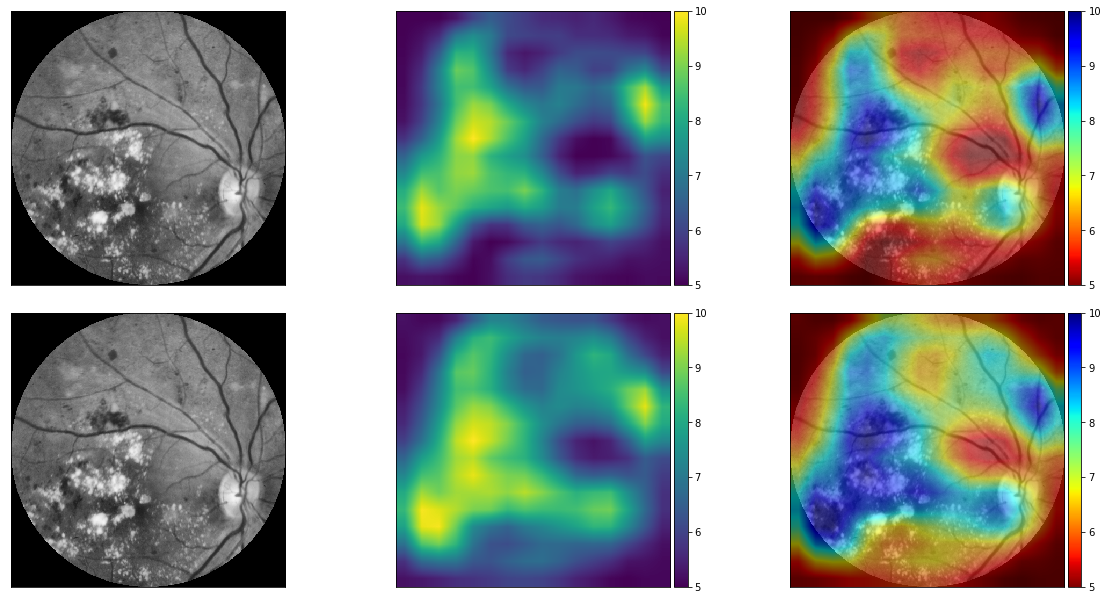

In [9]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

# Retrieve model
dataset = pd.read_csv("train.csv")
model = torch.load(MODEL_PATH).to(device)
model.eval().to(device)

# Prepare input image
id_code = "e4730ddde408"

img = cv2.imread(PREP_PATH + id_code + ".png", cv2.COLOR_BGR2RGB)[:, :, ::-1]
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)

print("Actual class: ", CLASSES[dataset.loc[dataset['id_code'] == id_code]['diagnosis'].values[0]])
outputs = model(input_tensor)
_, predicted = torch.max(outputs.data, 1)
print("Predicted class: ", CLASSES[predicted])

# Set target layers
target_layers = [model.layer4[-1]]

# GradCAM
gradcam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

grayscale_gradcam = gradcam(input_tensor=input_tensor, targets=None , eigen_smooth=False, aug_smooth=False)

grayscale_gradcam = grayscale_gradcam[0, :]

gradcam_image = show_cam_on_image(img, grayscale_gradcam)

# GradCAM++
gradcampp = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

grayscale_gradcampp = gradcampp(input_tensor=input_tensor, targets=None , eigen_smooth=False, aug_smooth=False)

grayscale_gradcampp = grayscale_gradcampp[0, :]

gradcampp_image = show_cam_on_image(img, grayscale_gradcampp)

fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.1)
cmap_viridis = mpl.cm.viridis
cmap_jet = mpl.cm.jet_r
norm = mpl.colors.Normalize(vmin=5, vmax=10)

ax1 = fig.add_subplot(231)
im1 = ax1.imshow(img, interpolation='None')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(232)
im2 = ax2.imshow(grayscale_gradcam, interpolation='None')
ax2.set_xticks([])
ax2.set_yticks([])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_viridis), cax=cax, orientation='vertical')

ax3 = fig.add_subplot(233)
im3 = ax3.imshow(gradcam_image, interpolation='None')
ax3.set_xticks([])
ax3.set_yticks([])

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_jet), cax=cax, orientation='vertical')

ax4 = fig.add_subplot(234)
im4 = ax4.imshow(img, interpolation='None')
ax4.set_xticks([])
ax4.set_yticks([])

ax5 = fig.add_subplot(235)
im5 = ax5.imshow(grayscale_gradcampp, interpolation='None')
ax5.set_xticks([])
ax5.set_yticks([])

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_viridis), cax=cax, orientation='vertical')

ax6 = fig.add_subplot(236)
im6 = ax6.imshow(gradcampp_image, interpolation='None')
ax6.set_xticks([])
ax6.set_yticks([])

divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_jet), cax=cax, orientation='vertical')